## Task Description:

The task is to develop a simplified algorithm that estimates the cycle costs required to achieve a specific average daily cycle count for an energy storage system while not breaching the maximum daily number of cycles.

### Theoretical background attached in pdf file.

### Inputs:
The inputs for the function should be (with default values you can use):
- **Price signals of a single market**: (see attachment)
- **The nominal power of the storage**: 2 MW
- **The usable capacity of the storage**: 4 MWh
- **The efficiency of the energy storage**: (0.9) 90%
- **The target average cycles per 24-hour time horizon**: 1.5
- **The maximum number of cycles per 24-hour time horizon**: 2.5

### Rules:
1. Account for the efficiency.
1. Consider storage limitations, including capacity and nominal power.
1. The target average cycles should drive the cycle costs, the maximum number of cycles for each day should be capped within the algorithm to ensure they are not violated.
1. The algorithm ideally goes over the price data with a rolling horizon, but the data can also be analyzed per day (from 00:00 to 00:00).
1. Use python for your solution.
1. **As a benchmark, the estimated cycle costs should be in a range of 20-36 €/MWh.**


# Solution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.optimize import linprog

In [2]:
market_prices_df = pd.read_csv(r"market_prices.csv", sep=';', parse_dates=['timestamp_UTC'])
market_prices_df.head()

,timestamp_UTC,price_idm_continuous_qh_vwap_EUR/MWh
0,2021-12-31 23:00:00,85.57
1,2021-12-31 23:15:00,36.80
2,2021-12-31 23:30:00,32.64
3,2021-12-31 23:45:00,32.08
4,2022-01-01 00:00:00,51.71


In [3]:
market_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp_UTC                         35040 non-null  datetime64[ns]
 1   price_idm_continuous_qh_vwap_EUR/MWh  35040 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.6 KB


In [4]:
market_prices_df = market_prices_df.rename(columns={market_prices_df.columns[1]: 'EUR/MWh'})
market_prices_df['date'] = market_prices_df['timestamp_UTC'].dt.date
daily_price_data = market_prices_df.groupby('date')['EUR/MWh'].apply(list).reset_index()
daily_price_data.head()

,date,EUR/MWh
0,2021-12-31,"[85.57, 36.8, 32.64, 32.08]"
1,2022-01-01,"[51.71, 63.94, 44.75, 39.13, 58.69, 43.58, 42...."
2,2022-01-02,"[203.92, 186.65, 170.89, 171.57, 181.16, 171.1..."
3,2022-01-03,"[205.44, 207.33, 207.03, 192.09, 184.46, 182.5..."
4,2022-01-04,"[75.08, 58.48, 85.07, 107.33, 123.39, 131.53, ..."


In [165]:
daily_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        366 non-null    object 
 1   EUR/MWh     366 non-null    object 
 2   cycle_cost  366 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.7+ KB


In [5]:
len(daily_price_data.iloc[1][1])

96

In [6]:
#Constraints:
nominal = 2  # in MW
capacity = 4  # in MWh
efficiency = 90 / 100  # 90%
target_average_cycles = 1.5
max_cycles_per_day = 2.5

# 1. The Combinatory Approach

In [7]:
#Define a function to calculate the daily cycles with most the spread, while considering storage limitations and efficiency.

def calculate_daily_cycles(price_data):
    num_intervals = len(price_data)
    best_spreads = []

    for buy_time, sell_time in combinations(range(num_intervals), 2):
        spread = (price_data[sell_time] * efficiency * efficiency) - price_data[buy_time]
        best_spreads.append((spread, buy_time, sell_time))

    best_spreads.sort(reverse=True)

    cycles = []
    used_intervals = set() #used instead of empty list for faster lookup time of if statement
    for spread, buy_time, sell_time in best_spreads:
        if buy_time not in used_intervals and sell_time not in used_intervals:
            required_input_energy = capacity / efficiency #Energy required to buy to fill up the battery's capacity
            bought_energy = min(nominal * (sell_time - buy_time) * 0.25, required_input_energy)
            charged_energy = bought_energy * efficiency
            discharge_energy = charged_energy * efficiency
            profit = price_data[sell_time]*discharge_energy - price_data[buy_time]*bought_energy

            cycles.append({
                'buy_time': buy_time,
                'sell_time': sell_time,
                'bought_energy':bought_energy,
                'charged_energy': charged_energy,
                'discharge_energy': discharge_energy,
                'buy_price': price_data[buy_time],
                'sell_price': price_data[sell_time],
                'spread': f'{round(spread, 2)} EUR',
                'profit': f'{round(profit, 2)} EUR' ,
            })

            used_intervals.update(range(buy_time, sell_time + 1))

            if len(cycles) >= max_cycles_per_day:
                break

    return cycles


# Test the function with data for one day
test_day_data = daily_price_data['EUR/MWh'].iloc[1]
calculate_daily_cycles(test_day_data)

[{'buy_time': 12,
  'sell_time': 72,
  'bought_energy': 4.444444444444445,
  'charged_energy': 4.0,
  'discharge_energy': 3.6,
  'buy_price': 7.43,
  'sell_price': 140.92,
  'spread': '106.72 EUR',
  'profit': '474.29 EUR'},
 {'buy_time': 3,
  'sell_time': 76,
  'bought_energy': 4.444444444444445,
  'charged_energy': 4.0,
  'discharge_energy': 3.6,
  'buy_price': 39.13,
  'sell_price': 125.87,
  'spread': '62.82 EUR',
  'profit': '279.22 EUR'},
 {'buy_time': 2,
  'sell_time': 84,
  'bought_energy': 4.444444444444445,
  'charged_energy': 4.0,
  'discharge_energy': 3.6,
  'buy_price': 44.75,
  'sell_price': 100.89,
  'spread': '36.97 EUR',
  'profit': '164.32 EUR'}]

In [8]:
def estimate_cycle_costs(cycles):
    total_purchase_cost = 0
    total_sales_revenue = 0
    total_energy_cycled = 0

    for cycle in cycles:
        total_purchase_cost += cycle['bought_energy'] * cycle['buy_price']
        total_sales_revenue += cycle['discharge_energy'] * cycle['sell_price']
        total_energy_cycled += cycle['bought_energy'] #Bought energy is used to represents a complete energy cycle as it was the intial input energy

    net_cost = total_purchase_cost - total_sales_revenue
    cycle_cost = net_cost / total_energy_cycled

    return cycle_cost

test_day_cycles = calculate_daily_cycles(daily_price_data['EUR/MWh'].iloc[1])
estimate_cycle_costs(test_day_cycles)

-68.83693333333332

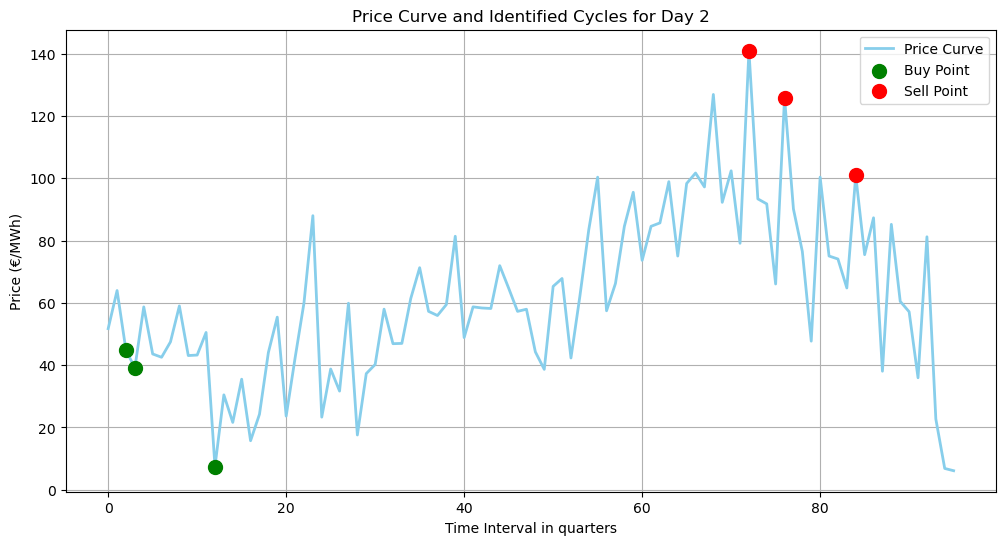

In [20]:
#The above value is showing a negative value for the cycle generated but not close to benchmark

#Visualizing the identified cycles on the price curve for day 2
day_2_data = daily_price_data['EUR/MWh'].iloc[1]
day_2_cycles = calculate_daily_cycles(day_2_data)

plt.figure(figsize=(12, 6))
plt.plot(day_2_data, label='Price Curve', color='skyblue', linewidth=2)

for cycle in day_2_cycles:
    plt.scatter(cycle['buy_time'], cycle['buy_price'], color='g', label='Buy Point', s=100, zorder=5)
    plt.scatter(cycle['sell_time'], cycle['sell_price'], color='r', label='Sell Point', s=100, zorder=5)

plt.xlabel('Time Interval in quarters')
plt.ylabel('Price (€/MWh)')
plt.title('Price Curve and Identified Cycles for Day 2')
plt.legend(['Price Curve', 'Buy Point', 'Sell Point'])
plt.grid(True)
plt.savefig("assets/images/Price Curve and Identified Cycles for Day 2.png", dpi=300)
plt.show()

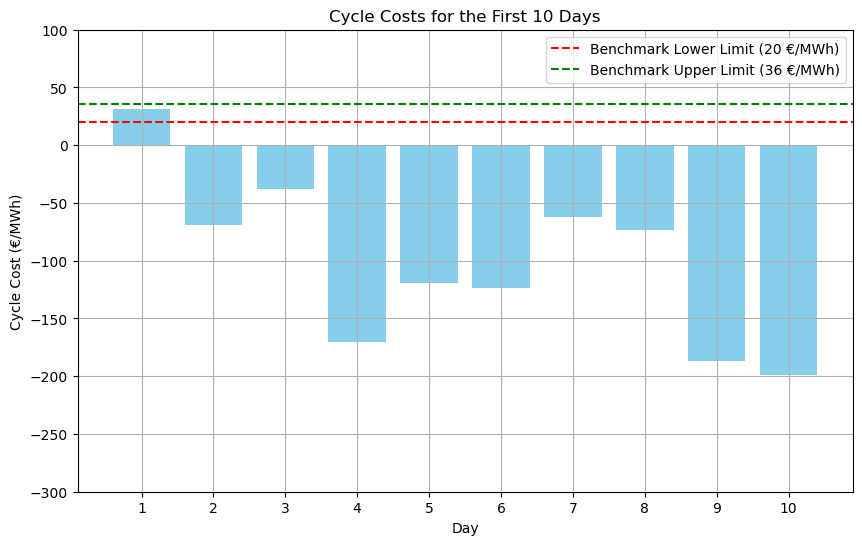

In [24]:
#Plot cycle costs of the first 10 days:
cycle_costs_list = daily_price_data['EUR/MWh'].iloc[0:10].apply(lambda x: estimate_cycle_costs(calculate_daily_cycles(x)))

plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), cycle_costs_list, color='skyblue')
plt.axhline(y=20, color='r', linestyle='--', label='Benchmark Lower Limit (20 €/MWh)')
plt.axhline(y=36, color='g', linestyle='--', label='Benchmark Upper Limit (36 €/MWh)')
plt.xlabel('Day')
plt.ylabel('Cycle Cost (€/MWh)')
plt.title('Cycle Costs for the First 10 Days')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 11))
plt.yticks(range(-300, 101, 50))
plt.savefig("assets/images/Cycle Costs for the First 10 Days.png", dpi=300)
plt.show()

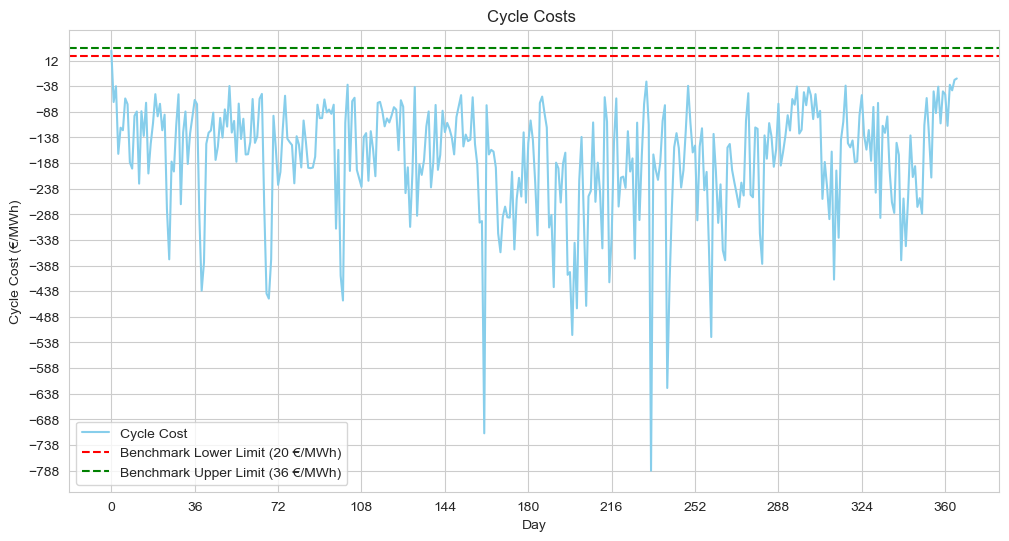

1 day(s) within benchmark.


In [143]:
#Plotting out final cycle cost estimations with best parameters using the Rolling Horizon approach.
daily_price_data['cycle_cost'] = daily_price_data['EUR/MWh'].apply(
    lambda x: estimate_cycle_costs(calculate_daily_cycles(x)))

plt.figure(figsize=(12, 6))

plt.plot(daily_price_data.index, daily_price_data['cycle_cost'], color='skyblue', label='Cycle Cost')
plt.axhline(y=20, color='r', linestyle='--', label='Benchmark Lower Limit (20 €/MWh)')
plt.axhline(y=36, color='g', linestyle='--', label='Benchmark Upper Limit (36 €/MWh)')
plt.xlabel('Day')
plt.ylabel('Cycle Cost (€/MWh)')
plt.title('Cycle Costs ')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(daily_price_data['cycle_cost']), int(len(daily_price_data['cycle_cost'])/10)))
plt.yticks(range(int(daily_price_data['cycle_cost'].min()), int(daily_price_data['cycle_cost'].max()), 50))
plt.show()
print(f"{((daily_price_data['cycle_cost'] >= 20) & (daily_price_data['cycle_cost'] <= 36)).sum()} day(s) within benchmark.")


In [107]:
#Investigating first day
estimate_cycle_costs(calculate_daily_cycles(daily_price_data['EUR/MWh'].iloc[1]))

-68.83693333333332

In [12]:
market_prices_df[market_prices_df['timestamp_UTC'].dt.date == pd.to_datetime('2021-12-31')]

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_11804\2250479810.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  market_prices_df[market_prices_df['timestamp_UTC'].dt.date == pd.to_datetime('2021-12-31')]


,timestamp_UTC,EUR/MWh,date
0,2021-12-31 23:00:00,85.57,2021-12-31
1,2021-12-31 23:15:00,36.80,2021-12-31
2,2021-12-31 23:30:00,32.64,2021-12-31
3,2021-12-31 23:45:00,32.08,2021-12-31


# 2. Rolling Horizon Approach
Since the first day yielded results that were within the benchmark using an hour's worth of date, a rolling horizon approach might be better to reach results within the bencmark.

In [131]:
#This function will calucalte the best cycles per day while attempting to reach the target average number of cycles per day as per the instructions
#Executing this approach will requrie initializing the average target cycles at zero and the function will adjust the maximum number of cycles
#it needs to calculate to get that avergae number of cycles close to the target
def calculate_daily_cycles_rolling_horizonv2(price_data, current_avg_cycles, horizon_length=8, step_size=1):
    num_intervals = len(price_data)
    best_cycles = []

    #Dynamically change max number of cycles per day based on the target and current average number of cycles
    max_cycles_per_day = min(2.5, max(1, target_average_cycles + (target_average_cycles - current_avg_cycles)))

    for start_time in range(0, num_intervals, step_size):
        end_time = min(start_time + horizon_length, num_intervals)
        best_spreads = []

        for buy_time, sell_time in combinations(range(start_time, end_time), 2):
            spread = (price_data[sell_time] * efficiency * efficiency) - price_data[buy_time]
            best_spreads.append((spread, buy_time, sell_time))

        best_spreads.sort(reverse=True)

        used_intervals = set()
        for spread, buy_time, sell_time in best_spreads:
            if buy_time not in used_intervals and sell_time not in used_intervals:
                required_input_energy = capacity / efficiency
                bought_energy = min(nominal * (sell_time - buy_time) * 0.25, required_input_energy)
                charged_energy = bought_energy * efficiency
                discharge_energy = charged_energy * efficiency
                profit = price_data[sell_time]*discharge_energy - price_data[buy_time]*bought_energy

                best_cycles.append({
                    'buy_time': buy_time,
                    'sell_time': sell_time,
                    'bought_energy': bought_energy,
                    'charged_energy': charged_energy,
                    'discharge_energy': discharge_energy,
                    'buy_price': price_data[buy_time],
                    'sell_price': price_data[sell_time],
                    'spread': f'{round(spread, 2)} EUR',
                    'profit': f'{round(profit, 2)} EUR' ,
                })

                used_intervals.update(range(buy_time, sell_time + 1))

                if len(best_cycles) >= max_cycles_per_day:
                    break

        if len(best_cycles) >= max_cycles_per_day:
            break

    return best_cycles


In [148]:
test_day_data = daily_price_data['EUR/MWh'].iloc[1]
calculate_daily_cycles_rolling_horizonv2(test_day_data, 0, horizon_length=8, step_size=1)

[{'buy_time': 3,
  'sell_time': 4,
  'bought_energy': 0.5,
  'charged_energy': 0.45,
  'discharge_energy': 0.405,
  'buy_price': 39.13,
  'sell_price': 58.69,
  'spread': '8.41 EUR',
  'profit': '4.2 EUR'},
 {'buy_time': 0,
  'sell_time': 1,
  'bought_energy': 0.5,
  'charged_energy': 0.45,
  'discharge_energy': 0.405,
  'buy_price': 51.71,
  'sell_price': 63.94,
  'spread': '0.08 EUR',
  'profit': '0.04 EUR'},
 {'buy_time': 6,
  'sell_time': 7,
  'bought_energy': 0.5,
  'charged_energy': 0.45,
  'discharge_energy': 0.405,
  'buy_price': 42.52,
  'sell_price': 47.46,
  'spread': '-4.08 EUR',
  'profit': '-2.04 EUR'}]

In [151]:
current_avg_cycles = 0
num_days = len(daily_price_data)

for i in range(num_days):
    daily_data = daily_price_data['EUR/MWh'].iloc[i]
    cycles = calculate_daily_cycles_rolling_horizonv2(daily_data, current_avg_cycles)
    cycle_cost = estimate_cycle_costs(cycles)
    daily_price_data.at[i, 'cycle_cost'] = cycle_cost
    current_avg_cycles = ((current_avg_cycles * i) + len(cycles)) / (i + 1)

within_benchmark = ((daily_price_data['cycle_cost'] >= 20) & (daily_price_data['cycle_cost'] <= 36)).sum()
print(f"The number of days with cycle costs within the benchmark range is: {within_benchmark}.\nCurrent Average Number of cycles: {round(current_avg_cycles, 3)}")


The number of days with cycle costs within the benchmark range is: 90.
Current Average Number of cycles: 1.997


In [136]:
#Trying out different parameters 
results = []

for horizon_length in [4, 8, 12, 16, 20, 24, 28, 32]:
    for step_size in [1, 2, 4, 6, 8, 10]:
        daily_cycle_costs = daily_price_data['EUR/MWh'].apply(
            lambda x: estimate_cycle_costs(calculate_daily_cycles_rolling_horizonv2(x, current_avg_cycles, horizon_length=horizon_length, step_size=step_size))
        )
        results.append({
            'horizon_length': horizon_length,
            'step_size': step_size,
            'average_cycle_cost': daily_cycle_costs.mean(),
            'days_within_benchmark': ((daily_cycle_costs >= 20) & (daily_cycle_costs <= 36)).sum()
        })


results_df = pd.DataFrame(results)
results_df.sort_values(by='days_within_benchmark',ascending=False).head()

,horizon_length,step_size,average_cycle_cost,days_within_benchmark
6,8,1,17.992188,90
7,8,2,18.071481,90
8,8,4,17.719041,89
9,8,6,17.834890,89
11,8,10,17.083114,89


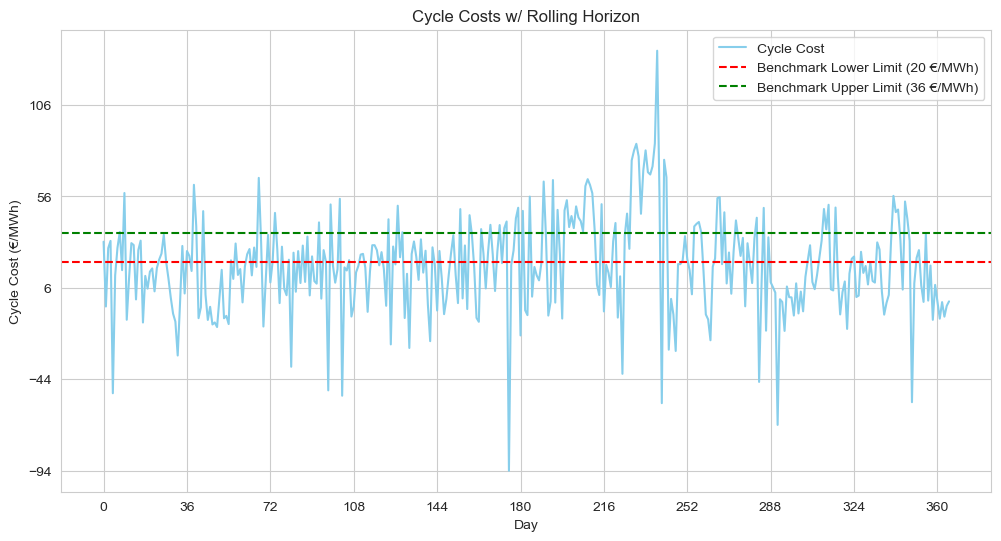

90 day(s) within benchmark. 
Current Average Number of cycles: 1.997


In [162]:
#Plotting out final cycle cost estimations with best parameters using the Rolling Horizon approach.
daily_price_data['cycle_cost'] = daily_price_data['EUR/MWh'].apply(
    lambda x: estimate_cycle_costs(calculate_daily_cycles_rolling_horizonv2(x, current_avg_cycles)))

plt.figure(figsize=(12, 6))

plt.plot(daily_price_data.index, daily_price_data['cycle_cost'], color='skyblue', label='Cycle Cost')
plt.axhline(y=20, color='r', linestyle='--', label='Benchmark Lower Limit (20 €/MWh)')
plt.axhline(y=36, color='g', linestyle='--', label='Benchmark Upper Limit (36 €/MWh)')
plt.xlabel('Day')
plt.ylabel('Cycle Cost (€/MWh)')
plt.title('Cycle Costs w/ Rolling Horizon')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(daily_price_data['cycle_cost']), int(len(daily_price_data['cycle_cost'])/10)))
plt.yticks(range(int(daily_price_data['cycle_cost'].min()), int(daily_price_data['cycle_cost'].max()), 50))
plt.show()
print(f"{((daily_price_data['cycle_cost'] >= 20) & (daily_price_data['cycle_cost'] <= 36)).sum()} day(s) within benchmark. \nCurrent Average Number of cycles: {round(current_avg_cycles, 3)}")

# 3. Constrained Optimization Approach

In [39]:
#Create function to generate all possible cycles for one day, important for defining decision variable.
def generate_possible_cycles(price_data, min_length=1):
    num_intervals = len(price_data)
    possible_cycles = []

    for buy_time, sell_time in combinations(range(num_intervals), 2):
        if sell_time - buy_time >= min_length:
            spread =  (price_data[sell_time] * efficiency * efficiency) - price_data[buy_time]
            required_input_energy = capacity / efficiency
            bought_energy = min(nominal * (sell_time - buy_time) * 0.25, required_input_energy)
            charged_energy = bought_energy * efficiency
            discharge_energy = charged_energy * efficiency
            profit = price_data[sell_time]*discharge_energy -price_data[buy_time]*bought_energy

            possible_cycles.append({
                'buy_time': buy_time,
                'sell_time': sell_time,
                'bought_energy': bought_energy,
                'charged_energy': charged_energy,
                'discharge_energy': discharge_energy,
                'buy_price': price_data[buy_time],
                'sell_price': price_data[sell_time],
                'spread': spread,
                'profit': profit,
            })

    return possible_cycles


sample_day_data = daily_price_data['EUR/MWh'].iloc[1]
sample_possible_cycles = generate_possible_cycles(sample_day_data)
sample_possible_cycles_df = pd.DataFrame(sample_possible_cycles)
sample_possible_cycles_df.head()

,buy_time,sell_time,bought_energy,charged_energy,discharge_energy,buy_price,sell_price,spread,profit
0,0,1,0.5,0.45,0.405,51.71,63.94,0.0814,0.04070
1,0,2,1.0,0.90,0.810,51.71,44.75,-15.4625,-15.46250
2,0,3,1.5,1.35,1.215,51.71,39.13,-20.0147,-30.02205
3,0,4,2.0,1.80,1.620,51.71,58.69,-4.1711,-8.34220
4,0,5,2.5,2.25,2.025,51.71,43.58,-16.4102,-41.02550


In [40]:
sample_possible_cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   buy_time          4560 non-null   int64  
 1   sell_time         4560 non-null   int64  
 2   bought_energy     4560 non-null   float64
 3   charged_energy    4560 non-null   float64
 4   discharge_energy  4560 non-null   float64
 5   buy_price         4560 non-null   float64
 6   sell_price        4560 non-null   float64
 7   spread            4560 non-null   float64
 8   profit            4560 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 320.8 KB


In [41]:
#Create function to generate possible cycles for all days
def generate_possible_cycles_for_all_days(daily_price_data, min_length=1):
    all_possible_cycles = []

    for day_index, price_data in enumerate(daily_price_data['EUR/MWh']):
        daily_possible_cycles = generate_possible_cycles(price_data, min_length)

        #add day index to each cycle to identify the day to which it belongs
        for cycle in daily_possible_cycles:
            cycle['day_index'] = day_index

        all_possible_cycles.extend(daily_possible_cycles)

    return all_possible_cycles

all_possible_cycles = generate_possible_cycles_for_all_days(daily_price_data)
all_possible_cycles_df = pd.DataFrame(all_possible_cycles)
all_possible_cycles_df.head(), all_possible_cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664032 entries, 0 to 1664031
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   buy_time          1664032 non-null  int64  
 1   sell_time         1664032 non-null  int64  
 2   bought_energy     1664032 non-null  float64
 3   charged_energy    1664032 non-null  float64
 4   discharge_energy  1664032 non-null  float64
 5   buy_price         1664032 non-null  float64
 6   sell_price        1664032 non-null  float64
 7   spread            1664032 non-null  float64
 8   profit            1664032 non-null  float64
 9   day_index         1664032 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 127.0 MB


(   buy_time  sell_time  bought_energy  charged_energy  discharge_energy  \
 0         0          1            0.5            0.45             0.405   
 1         0          2            1.0            0.90             0.810   
 2         0          3            1.5            1.35             1.215   
 3         1          2            0.5            0.45             0.405   
 4         1          3            1.0            0.90             0.810   
 
    buy_price  sell_price   spread   profit  day_index  
 0      85.57       36.80 -55.7620 -27.8810          0  
 1      85.57       32.64 -59.1316 -59.1316          0  
 2      85.57       32.08 -59.5852 -89.3778          0  
 3      36.80       32.64 -10.3616  -5.1808          0  
 4      36.80       32.08 -10.8152 -10.8152          0  ,
 None)

In [43]:
#Using linear programming
days_number = daily_price_data.shape[0]

profits = all_possible_cycles_df['profit'].values
day_indices = all_possible_cycles_df['day_index'].values
c = -profits
lambda_penalty = 1e6

A_eq_daily = np.zeros((days_number, len(profits)))
for i in range(days_number):
    A_eq_daily[i, day_indices == i] = 1

A_eq_average = np.ones((1, len(profits)))

A_eq = np.vstack([A_eq_daily, A_eq_average])
b_eq = np.hstack([np.full(days_number, max_cycles_per_day), [target_average_cycles * days_number]])

c_extended = np.append(c, lambda_penalty)#Extend c to account for the penalty on the deviation variable delta


A_eq_delta = np.append(np.ones(len(profits)), [-1]).reshape(1, -1)
A_eq = np.hstack([A_eq, np.zeros((A_eq.shape[0], 1))])  # Add a column for delta to A_eq
A_eq[-1, :] = A_eq_delta  # Update the last row with A_eq_delta


bounds = [(0, 1) for _ in profits] + [(0, None)]
print(A_eq.shape, b_eq.shape)


(367, 1664033) (367,)


In [44]:
res_option_b = linprog(c_extended, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
print(res_option_b)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 365095106.33555603
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  3.660e+02]
            nit: 375
          lower:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              3.660e+02]
                 marginals: [ 1.707e+01  4.832e+01 ...  1.425e+02
                              0.000e+00]
          upper:  residual: [ 1.000e+00  1.000e+00 ...  1.000e+00
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 1.000e+06  9.996e+05 ...  9.999e+05
                             -1.000e+06]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mi

In [21]:
type(res_option_b)

scipy.optimize._optimize.OptimizeResult

In [45]:
x_values = res_option_b['x'][:-1]
suggested_cycle_indexes = np.where(x_values == 1)[0]
suggested_cycles_df = all_possible_cycles_df.iloc[suggested_cycle_indexes]
suggested_cycles_df

,buy_time,sell_time,bought_energy,charged_energy,discharge_energy,buy_price,sell_price,spread,profit,day_index
3,1,2,0.500000,0.45,0.405,36.80,32.64,-10.3616,-5.180800,0
5,2,3,0.500000,0.45,0.405,32.64,32.08,-6.6552,-3.327600,0
1139,12,72,4.444444,4.00,3.600,7.43,140.92,106.7152,474.289778,1
1461,16,72,4.444444,4.00,3.600,15.73,140.92,98.4152,437.400889,1
8641,64,76,4.444444,4.00,3.600,54.19,112.70,37.0970,164.875556,2
...,...,...,...,...,...,...,...,...,...,...
1652487,20,72,4.444444,4.00,3.600,-16.45,63.67,68.0227,302.323111,363
1656374,12,27,4.444444,4.00,3.600,-10.61,21.86,28.3166,125.851556,364
1656696,16,27,4.444444,4.00,3.600,-11.50,21.86,29.2066,129.807111,364
1660180,3,68,4.444444,4.00,3.600,-3.94,34.59,31.9579,142.035111,365


In [92]:
suggested_df = suggested_cycles_df.groupby('day_index').apply(lambda x: x.to_dict('records'))

In [94]:
suggested_df.apply(estimate_cycle_costs)

day_index
0        8.5084
1     -102.5652
2      -35.2502
3     -288.5435
4     -139.4111
         ...   
361   -122.8510
362    -41.1463
363    -66.6927
364    -28.7616
365    -31.8929
Length: 366, dtype: float64

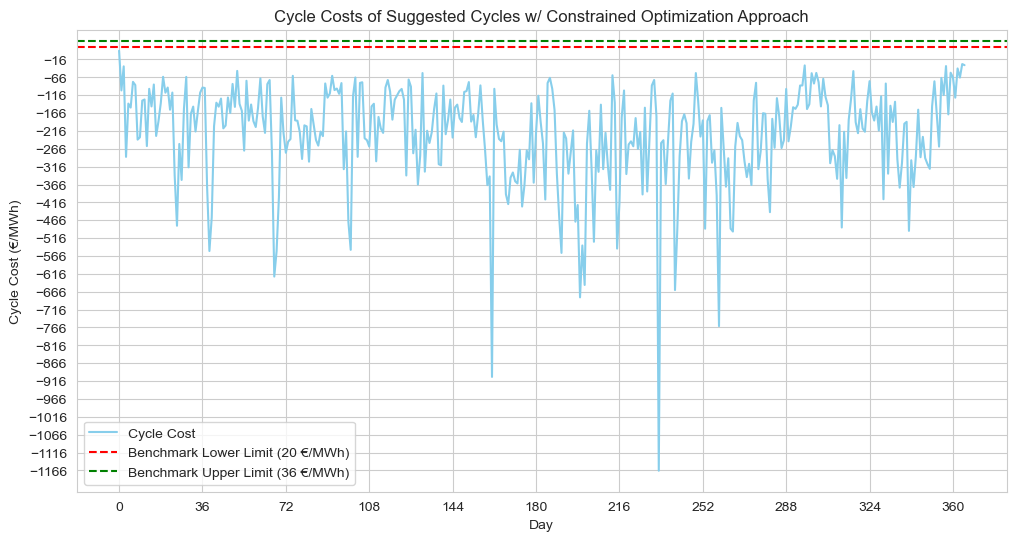

0 day(s) within benchmark.


In [164]:
#Plotting out final cycle cost estimations with best parameters using the Rolling Horizon approach.
daily_price_data['cycle_cost'] = suggested_df.apply(estimate_cycle_costs)

plt.figure(figsize=(12, 6))

plt.plot(daily_price_data.index, daily_price_data['cycle_cost'], color='skyblue', label='Cycle Cost')
plt.axhline(y=20, color='r', linestyle='--', label='Benchmark Lower Limit (20 €/MWh)')
plt.axhline(y=36, color='g', linestyle='--', label='Benchmark Upper Limit (36 €/MWh)')
plt.xlabel('Day')
plt.ylabel('Cycle Cost (€/MWh)')
plt.title('Cycle Costs of Suggested Cycles w/ Constrained Optimization Approach')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(daily_price_data['cycle_cost']), int(len(daily_price_data['cycle_cost'])/10)))
plt.yticks(range(int(daily_price_data['cycle_cost'].min()), int(daily_price_data['cycle_cost'].max()), 50))
plt.savefig("assets/images/optimization approach.png", dpi=300)
plt.show()

print(f"{((daily_price_data['cycle_cost'] >= 20) & (daily_price_data['cycle_cost'] <= 36)).sum()} day(s) within benchmark.")

In [152]:
print(f"Total costs of selected cycles with the Combinatory Approach:\n{daily_price_data['EUR/MWh'].apply(lambda x:estimate_cycle_costs(calculate_daily_cycles(x))).sum()}\n")
print(f"Total costs of selected cycles with the Rolling Horizon Approach:\n{daily_price_data['EUR/MWh'].apply(lambda x:estimate_cycle_costs(calculate_daily_cycles_rolling_horizonv2(x, 0))).sum()}\n")
print(f"Total costs of selected cycles with the Constrained Optimization Approach:\n{suggested_df.apply(estimate_cycle_costs).sum()}\n")


Total costs of selected cycles with the Combinatory Approach:
-65250.43239985398

Total costs of selected cycles with the Rolling Horizon Approach:
8673.51469943505

Total costs of selected cycles with the Constrained Optimization Approach:
-82084.92143421053

